In [1]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

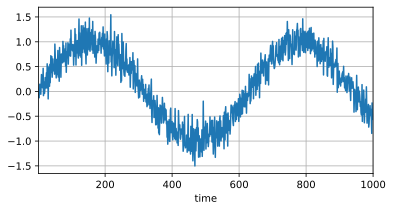

In [2]:
T = 1000 # 产生1000个点
time = torch.arange(1, T + 1, dtype=torch.float32)
# torch.normal(0, 0.2, (T,) 生成一个均值为0、标准差为0.2、长度为 T 的正态分布噪声张量
x = torch.sin(0.01 * time) + torch.normal(0, 0.2, (T,))
d2l.plot(time, [x], 'time', xlim=[1, 1000], figsize=(6,3))

In [3]:
# 时间步 tau，表示我们将用过去 tau 个时间点的数据来预测下一个时间点的数据
tau = 4
# features 存储时间序列的特征。
features = torch.zeros((T - tau, tau))
'''
整个循环的过程是：
- 当 `i=0` 时，取 `x` 的前 `T - tau` 个元素填充 `features` 的第一列。
- 当 `i=1` 时，取从第1个元素到第 `T - tau + 1` 个元素填充 `features` 的第二列。
- 依此类推，直到 `i=tau-1`。

最终，每一行的特征向量包含时间序列中连续的 `tau` 个数据点。
'''
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
'''
- `x[tau:]` 表示从第 `tau` 个元素到最后一个元素的子序列。这些是每个特征向量所对应的目标值。
- `.reshape((-1, 1))` 将这个子序列重塑为一个二维张量，使其形状为 `(T - tau, 1)`，即每一行对应一个标签值。
'''
labels = x[tau:].reshape((-1, 1))

'''
综上所述，这段代码的目的在于：
- 生成一个特征张量 `features`，其中每行包含时间序列中连续的 `tau` 个数据点。
- 生成一个标签张量 `labels`，其中每行包含对应的目标值，即在特征向量之后的一个数据点。
'''

print("Features shape:", features.shape)
print("Labels shape:", labels.shape)
print("First 5 features:\n", features[:5])
print("First 5 labels:\n", labels[:5])

Features shape: torch.Size([996, 4])
Labels shape: torch.Size([996, 1])
First 5 features:
 tensor([[-0.0862, -0.1008, -0.1273,  0.0566],
        [-0.1008, -0.1273,  0.0566,  0.1442],
        [-0.1273,  0.0566,  0.1442, -0.0504],
        [ 0.0566,  0.1442, -0.0504,  0.0066],
        [ 0.1442, -0.0504,  0.0066, -0.0567]])
First 5 labels:
 tensor([[ 0.1442],
        [-0.0504],
        [ 0.0066],
        [-0.0567],
        [ 0.1439]])


In [4]:
batch_size, n_train = 16, 600
# 只有前n_train个样本用于训练
train_iter = d2l.load_array(
    (
        features[:n_train],
        labels[:n_train]
    ),
    batch_size,
    is_train=True
)

In [5]:
# 初始化网络权重的函数
def init_weights(m):
    if type(m) == nn.Linear:
        # 使用 Xavier 初始化方法（也称为 Glorot 初始化）来初始化 nn.Linear 层的权重
        nn.init.xavier_uniform_(m.weight)


In [6]:
# 一个简单的多层感知机
def get_net():
    net = nn.Sequential(
        nn.Linear(4, 10),
        nn.ReLU(),
        nn.Linear(10, 1)
    )
    net.apply(init_weights)
    return net

In [7]:
# 平方损失。注意：MSELoss计算平方误差时不带系数1/2
# 均方误差（Mean Squared Error, MSE）损失函数
# 均方误差是回归任务中常用的损失函数
loss = nn.MSELoss(reduction='none')

In [8]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.sum().backward()
            trainer.step()
        print(
            f'epoch {epoch + 1},'
            f'loss: {d2l.evaluate_loss(net, train_iter, loss):f}'
        )

In [9]:
net = get_net()
train(net, train_iter, loss, 5, 0.01)

epoch 1,loss: 0.063396
epoch 2,loss: 0.057643
epoch 3,loss: 0.056423
epoch 4,loss: 0.059031
epoch 5,loss: 0.054426


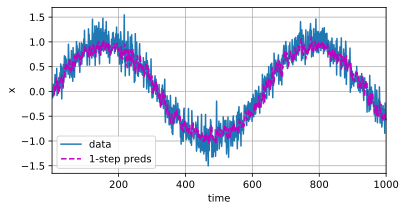

In [10]:

'''
time: tensor([   1.,    2.,    3.,    4.,    5.,    6.,    7.,    8.,    9.,   10.,
          11.,   12.,   13.,   14.,   15.,   16.,   17.,   18.,   19.,   20.,
          ...
         981.,  982.,  983.,  984.,  985.,  986.,  987.,  988.,  989.,  990.,
         991.,  992.,  993.,  994.,  995.,  996.,  997.,  998.,  999., 1000.])

time.shape: torch.Size([1000])

time[tau:]: tensor([   5.,    6.,    7.,    8.,    9.,   10.,   11.,   12.,   13.,   14.,
          15.,   16.,   17.,   18.,   19.,   20.,   21.,   22.,   23.,   24.,
         ...
         985.,  986.,  987.,  988.,  989.,  990.,  991.,  992.,  993.,  994.,
         995.,  996.,  997.,  998.,  999., 1000.])

time[tau:].shape: torch.Size([996])

x: tensor([-1.5027e-01,  1.0529e-01, -4.3786e-04, -9.6814e-02,  1.1957e-01,
         3.7557e-02,  4.2766e-02,  7.0278e-02,  3.2900e-02, -1.3402e-01,
         ...
        -6.3251e-01, -4.8339e-01, -1.7987e-01, -4.3708e-01, -4.1941e-01,
        -5.3255e-01, -7.8850e-01, -7.0646e-01, -1.1856e-01, -6.9832e-01])

x.shape: torch.Size([1000])

x.detach(): tensor([-1.5027e-01,  1.0529e-01, -4.3786e-04, -9.6814e-02,  1.1957e-01,
         3.7557e-02,  4.2766e-02,  7.0278e-02,  3.2900e-02, -1.3402e-01,
         ...
        -6.3251e-01, -4.8339e-01, -1.7987e-01, -4.3708e-01, -4.1941e-01,
        -5.3255e-01, -7.8850e-01, -7.0646e-01, -1.1856e-01, -6.9832e-01])

x.detach().shape: torch.Size([1000])

x.detach().numpy(): [-1.50272951e-01  1.05294570e-01 -4.37863171e-04 -9.68137980e-02
  1.19569972e-01  3.75569388e-02  4.27662209e-02  7.02779293e-02
  ...
 -1.79874629e-01 -4.37077194e-01 -4.19413149e-01 -5.32548070e-01
 -7.88495719e-01 -7.06463814e-01 -1.18557572e-01 -6.98324025e-01]
 
x.detach().numpy().shape: (1000,)

onestep_preds: tensor([[-2.6201e-02],
        [ 6.3840e-02],
        [ 4.9039e-02],
        ...
        [-5.5125e-01],
        [-6.0283e-01],
        [-5.8001e-01]], grad_fn=<AddmmBackward0>)

onestep_preds.shape: torch.Size([996, 1])

onestep_preds.detach(): tensor([[-2.6201e-02],
        [ 6.3840e-02],
        [ 4.9039e-02],
        ...
   
        [-4.2984e-01],
        [-5.5125e-01],
        [-6.0283e-01],
        [-5.8001e-01]])

onestep_preds.detach().shape: torch.Size([996, 1])     

onestep_preds.detach().numpy(): [[-2.62011737e-02]
 [ 6.38403445e-02]
 [ 4.90389317e-02]
 [ 5.28313667e-02]
 
 [-5.51245809e-01]
 [-6.02825820e-01]
 [-5.80014467e-01]]
onestep_preds.detach().numpy().shape: (996, 1)
'''
onestep_preds = net(features)
d2l.plot(
    [time, time[tau:]],
    [
        x.detach().numpy(),
        onestep_preds.detach().numpy()
    ],
    'time',
    'x',
    legend=['data', '1-step preds'],
    xlim=[1, 1000],
    figsize=(6,3)
)


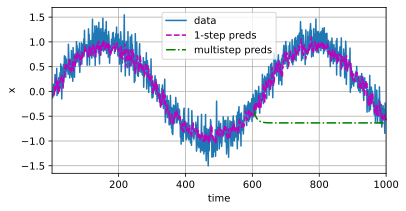

In [11]:
# T: 1000
multistep_preds = torch.zeros(T)
# n_train: 600，tau: 4
multistep_preds[: n_train + tau] = x[: n_train + tau]
'''
multistep_preds: tensor([-1.5027e-01,  1.0529e-01, -4.3786e-04, -9.6814e-02,  1.1957e-01,
         3.7557e-02,  4.2766e-02,  7.0278e-02,  3.2900e-02, -1.3402e-01,
         2.2889e-01,  1.0750e-01,  1.9052e-01,  1.3445e-01, -5.6249e-02,
         ...
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00])
         
'''

for i in range(n_train + tau, T):
    multistep_preds[i] = net(
        multistep_preds[i - tau:i].reshape((1, -1))
    )
    '''
    第一轮迭代：
    i: 604
    i - tau: 600
    multistep_preds[i - tau:i]: tensor([-0.3181, -0.3626,  0.1393, -0.4205], grad_fn=<SliceBackward0>)
    multistep_preds[i - tau:i].shape: torch.Size([4])
    multistep_preds[i - tau:i].reshape((1, -1)): tensor([[-0.3181, -0.3626,  0.1393, -0.4205]], grad_fn=<ReshapeAliasBackward0>)
    multistep_preds[i - tau:i].reshape((1, -1)).shape: torch.Size([1, 4])

    第二轮迭代：
    
    i: 605
    i - tau: 601
    multistep_preds[i - tau:i]: tensor([-0.3626,  0.1393, -0.4205, -0.3082], grad_fn=<SliceBackward0>)
    multistep_preds[i - tau:i].shape: torch.Size([4])
    multistep_preds[i - tau:i].reshape((1, -1)): tensor([[-0.3626,  0.1393, -0.4205, -0.3082]], grad_fn=<ReshapeAliasBackward0>)
    multistep_preds[i - tau:i].reshape((1, -1)).shape: torch.Size([1, 4])
    '''
d2l.plot(
    [
        time,
        time[tau:],
        time[n_train + tau:]
    ],
    [
        x.detach().numpy(),
        onestep_preds.detach().numpy(),
        multistep_preds[n_train + tau:].detach().numpy()
    ],
    'time',
    'x',
    legend=[
        'data', 
        '1-step preds',
        'multistep preds'
    ],
    xlim=[1, 1000],
    figsize=(6,3)
)
# print("multistep_preds:",multistep_preds)
# print("tau:",tau)

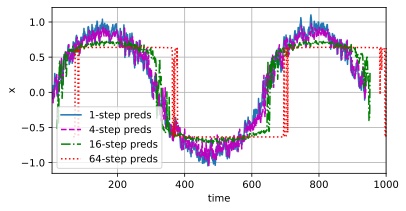

In [12]:
max_steps = 64

features = torch.zeros(
    (
        T - tau -max_steps + 1,
        tau + max_steps
    ) 
)
'''
T - tau -max_steps + 1: 933
tau + max_steps: 68
feature.shape torch.Size([933, 68])

range(tau): range(0, 4)
'''


# 列i（i<tau）是来自x的观测，其时间步从（i）到（i+T-tau-max_step+1）
for i in range(tau):
    features[:,i] = x[i: i + T - tau - max_steps + 1]
    '''
    第一次迭代：
    i: 0
    i + T - tau - max_steps + 1: 933
    features[:,i]: tensor([-4.9095e-02, -1.0286e-01, -3.6101e-01, -1.0005e-01,  1.6747e-01,
         2.8400e-01,  1.5722e-01,  2.3532e-02,  2.6882e-01,  1.3812e-01,
         ...
         2.7229e-01,  5.8316e-01,  1.1119e-01,  4.9153e-01,  3.3797e-01,
         1.7047e-01, -9.4798e-02,  1.4354e-01])

    features[:,i].shape: torch.Size([933])

    第二次迭代： 
    i: 1
    i + T - tau - max_steps + 1: 934
    features[:,i]: tensor([-1.3448e-01, -1.0410e-01, -5.7452e-02,  3.5873e-01,  2.1497e-01,
             2.1708e-01, -1.1360e-01,  6.5719e-02, -5.8331e-02, -1.3668e-01,
             ...
             1.0033e-01,  1.6010e-01,  1.6283e-01, -5.9647e-02,  1.6626e-01,
            -5.7218e-02,  2.4028e-02,  9.2819e-02])
    features[:,i].shape: torch.Size([933])

    第三次迭代：
    i: 2
    i + T - tau - max_steps + 1: 935
    features[:,i]: tensor([-1.0410e-01, -5.7452e-02,  3.5873e-01,  2.1497e-01,  2.1708e-01,
            -1.1360e-01,  6.5719e-02, -5.8331e-02, -1.3668e-01,  1.5172e-01,
            ...
             1.6010e-01,  1.6283e-01, -5.9647e-02,  1.6626e-01, -5.7218e-02,
             2.4028e-02,  9.2819e-02, -4.8505e-02])
    features[:,i].shape: torch.Size([933])
    
    '''

# 列i (i>=tau) 是来自（i-tau+1）步的预测，其时间步从（i）到（i+T-Tau-max_steps+1）
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = (1, 4, 16,64)

d2l.plot(
    [time[tau + i -1: T - max_steps + i] for i in steps],
    [features[:, (tau + i -1)].detach().numpy() for i in steps],
    'time',
    'x',
    legend=[f'{i}-step preds' for i in steps],
    xlim=[5, 1000],
    figsize=(6, 3)
)
    